In [1]:
from math import factorial
import sympy as sp

In [2]:
def sym_basis_k_symbolic(k, d=3):
    basis = []

    # Factorials and sqrt become symbolic
    factorial = sp.factorial
    sqrt = sp.sqrt

    def generate(remain, parts):
        if len(parts) == d - 1:
            parts = parts + [remain]
            a, b, c = parts

            norm = sqrt(factorial(a) * factorial(b) * factorial(c) / factorial(k))
            basis.append((tuple(parts), sp.simplify(norm)))
            return

        for i in range(remain, -1, -1):
            generate(remain - i, parts + [i])

    generate(k, [])
    return basis


# Test
for vec, norm in sym_basis_k_symbolic(4):
    print(vec, norm)

(4, 0, 0) 1
(3, 1, 0) 1/2
(3, 0, 1) 1/2
(2, 2, 0) sqrt(6)/6
(2, 1, 1) sqrt(3)/6
(2, 0, 2) sqrt(6)/6
(1, 3, 0) 1/2
(1, 2, 1) sqrt(3)/6
(1, 1, 2) sqrt(3)/6
(1, 0, 3) 1/2
(0, 4, 0) 1
(0, 3, 1) 1/2
(0, 2, 2) sqrt(6)/6
(0, 1, 3) 1/2
(0, 0, 4) 1


In [3]:
import sympy as sp
from functools import lru_cache


def pi_symmetric_multinomial_opt(M, basis, numeric=False):
    """
    Compute the symmetric multinomial projection of M on the given basis.

    Args:
        M (sp.Matrix): d x d symbolic matrix.
        basis (list): List of (vector, norm) tuples from sym_basis_k_symbolic.
        numeric (bool): If True, evaluates numerically to speed up large k.

    Returns:
        sp.Matrix: Projected matrix.
    """
    d = M.rows
    n = len(basis)
    piM = sp.zeros(n, n)
    factorial = sp.factorial

    # Maximum degree k (all basis vectors have same degree)
    max_k = sum(basis[0][0])
    factorials = [factorial(i) for i in range(max_k + 1)]

    # Precompute powers of M
    powers = {}
    for u in range(d):
        for v in range(d):
            powers[(u, v)] = [1]  # M[u,v]^0
            val = 1
            for t in range(1, max_k + 1):
                val *= M[u, v]
                powers[(u, v)].append(val)

    # Function to enumerate contingency matrices
    def enum_contingency(rows, cols):
        @lru_cache(maxsize=None)
        def _recurse(row_idx, cols_remaining):
            cols_remaining = list(cols_remaining)
            if row_idx == len(rows):
                if all(c == 0 for c in cols_remaining):
                    return [()]
                return []
            results = []
            target = rows[row_idx]

            def compose(pos, left, current):
                if pos == len(cols_remaining) - 1:
                    val = left
                    if val <= cols_remaining[pos]:
                        yield tuple(current + [val])
                    return
                maxv = min(left, cols_remaining[pos])
                for v in range(maxv, -1, -1):
                    yield from compose(pos + 1, left - v, current + [v])

            for row_choice in compose(0, target, []):
                new_cols = tuple(cols_remaining[j] - row_choice[j] for j in range(len(cols_remaining)))
                for tail in _recurse(row_idx + 1, new_cols):
                    results.append(tuple(row_choice) + tail)
            return results

        return _recurse(0, tuple(cols))

    # Compute projection matrix
    for i_idx, (vec_i, norm_i) in enumerate(basis):
        for j_idx, (vec_j, norm_j) in enumerate(basis):
            val = 0
            for mat_flat in enum_contingency(tuple(vec_i), tuple(vec_j)):
                term = 1
                denom = 1
                for u in range(d):
                    for v in range(d):
                        t = mat_flat[u * d + v]
                        if t:
                            term *= powers[(u, v)][t]
                            denom *= factorials[t]
                val += factorials[max_k] / denom * term
            piM[i_idx, j_idx] = norm_i * norm_j * val
            if numeric:
                piM[i_idx, j_idx] = sp.N(piM[i_idx, j_idx])

    return piM

In [4]:
# import numpy as np
# import sympy as sp
# from file_handler import save_sympy_matrix
# # --- symbolic π(M) setup ---
# d = 3
# for i in range(1, 16):
#     k_val = i
#     # symbolic 3×3 matrix
#     M_sym = sp.Matrix(d, d, lambda i, j: sp.symbols(chr(97 + i * d + j)))
#     basis = sym_basis_k_symbolic(k_val, d)
#     piM_sym = pi_symmetric_multinomial_opt(M_sym, basis)
#     save_sympy_matrix(piM_sym, f"piM_sym_{k_val}.csv")
# # display(piM_sym)

In [5]:
# from file_handler import read_sympy_matrix_csv

# mx = read_sympy_matrix_csv("matrix.csv")
# mx

In [6]:
def generate_young_diagrams(n, max_rows=3):
    """Generate all valid Young diagrams with n boxes and up to max_rows rows."""

    def partitions(n, max_len, max_val):
        if n == 0:
            return [[]]
        if max_len == 0:
            return []
        result = []
        for i in range(min(n, max_val), 0, -1):
            for tail in partitions(n - i, max_len - 1, i):
                result.append([i] + tail)
        return result

    # Pad with zeros so all diagrams have exactly max_rows rows
    raw = partitions(n, max_rows, n)
    return [tuple(p + [0] * (max_rows - len(p))) for p in raw if len(p) <= max_rows]


print(f"n={5}: {generate_young_diagrams(5)}")

n=5: [(5, 0, 0), (4, 1, 0), (3, 2, 0), (3, 1, 1), (2, 2, 1)]


In [7]:
def dynkin_labels(diagram):
    λ1, λ2, λ3 = diagram[:3]
    return (λ1 - λ2, λ2 - λ3)


def standard_tableaux_count(shape):
    n = sum(shape)
    hooks = []
    rows = shape
    for i in range(len(rows)):
        for j in range(rows[i]):
            hook_len = rows[i] - j
            for k in range(i + 1, len(rows)):
                if j < rows[k]:
                    hook_len += 1
            hooks.append(hook_len)
    product = 1
    for h in hooks:
        product *= h
    return factorial(n) // product


def su3_dimension(a, b):
    return (a + 1) * (b + 1) * (a + b + 2) // 2

In [8]:
def reduce_full_3cols(shape):
    """
    Remove as many full 3-columns as possible from a Young diagram.
    Example: (3,1,1) → (2,0,0) with det_power = 1
    Returns (reduced_shape, det_power)
    """
    # smallest row length
    full_cols = min(shape)
    reduced = tuple(r - full_cols for r in shape)
    return reduced, full_cols


def expand_by_full_3cols(shape, k):
    """
    Add k full 3-columns (inverse of reduce_full_3cols).
    Example: expand_by_full_3cols((2,0,0),1) → (3,1,1)
    """
    expanded = tuple(r + k for r in shape)
    return expanded


tests = [(3, 1, 1), (2, 2, 1), (1, 1, 1), (4, 2, 1), (2, 0, 0)]
for s in tests:
    red, k = reduce_full_3cols(s)
    exp = expand_by_full_3cols(red, k)
    print(f"{s} → reduced {red} det^{k} → expand→ {exp}")

(3, 1, 1) → reduced (2, 0, 0) det^1 → expand→ (3, 1, 1)
(2, 2, 1) → reduced (1, 1, 0) det^1 → expand→ (2, 2, 1)
(1, 1, 1) → reduced (0, 0, 0) det^1 → expand→ (1, 1, 1)
(4, 2, 1) → reduced (3, 1, 0) det^1 → expand→ (4, 2, 1)
(2, 0, 0) → reduced (2, 0, 0) det^0 → expand→ (2, 0, 0)


In [9]:
def single_row_or_column_shapes(max_boxes, max_rows=3):
    """
    Generate all Young diagrams that are either:
      - a single row (k,0,0)
      - a single column (1,1,...,0,...)
    up to max_boxes boxes total.
    """
    shapes = []

    # Single rows
    for k in range(1, max_boxes + 1):
        shapes.append((k, 0, 0))

    # Single columns (length 1..max_rows)
    for k in range(1, min(max_boxes, max_rows) + 1):
        col = tuple([1] * k + [0] * (max_rows - k))
        shapes.append(col)

    # Remove duplicates and sort lexicographically (optional)
    uniq = []
    seen = set()
    for s in shapes:
        if s not in seen:
            uniq.append(s)
            seen.add(s)
    return uniq


print(single_row_or_column_shapes(5))
print(single_row_or_column_shapes(3))

[(1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0), (5, 0, 0), (1, 1, 0), (1, 1, 1)]
[(1, 0, 0), (2, 0, 0), (3, 0, 0), (1, 1, 0), (1, 1, 1)]


In [10]:
def diagram_to_cells(shape):
    """Return set of (row, col) coordinates for boxes (0-indexed)."""
    cells = set()
    for i, r in enumerate(shape):
        for j in range(r):
            cells.add((i, j))
    return cells


print(diagram_to_cells((3, 1, 0)))  # expect {(0,0),(0,1),(0,2),(1,0)}

{(0, 1), (1, 0), (0, 2), (0, 0)}


In [11]:
def is_vertical_strip(base_shape, new_shape):
    """
    Return True if new_shape can be obtained from base_shape by adding boxes
    that form a *vertical strip*, i.e.:

      - new_shape includes base_shape
      - no two added boxes in the same row
      - each added box is placed directly below an existing box
      - added boxes do not appear side-by-side in the same row
    """

    base = diagram_to_cells(base_shape)
    new = diagram_to_cells(new_shape)
    added = new - base
    if not added:
        return False

    # Must contain base
    if not base.issubset(new):
        return False

    # No two added boxes in the same row
    if len({i for i, _ in added}) != len(added):
        return False

    # Each added box should be directly below an existing one
    for i, j in added:
        if i == 0 or (i - 1, j) not in base:
            return False

    return True


def is_horizontal_strip(base_shape, new_shape):
    """
    Return True if new_shape can be obtained from base_shape by adding boxes
    that form a *horizontal strip*, i.e.:

      - new_shape includes base_shape
      - no two added boxes in the same column
      - each added box extends an existing row (to the right)
      - added boxes do not appear below one another in the same column
    """

    base = diagram_to_cells(base_shape)
    new = diagram_to_cells(new_shape)
    added = new - base
    if not added:
        return False

    # Must contain base
    if not base.issubset(new):
        return False

    # No two added boxes in the same column
    if len({j for _, j in added}) != len(added):
        return False

    # All added boxes extend an existing row directly to the right
    for i, j in added:
        # Row must have existed before
        if base_shape[i] == 0:
            return False
        # Must sit exactly at end of that row
        if j != base_shape[i]:
            return False
        # Must not stack vertically (no added box under an existing one)
        if i > 0 and (i - 1, j) in new:
            return False

    return True


a = (2, 1, 0)
print(is_horizontal_strip(a, (3, 1, 0)), is_vertical_strip(a, (3, 1, 0)))  # → True, False
print(is_horizontal_strip(a, (2, 2, 0)), is_vertical_strip(a, (2, 2, 0)))  # → False, True
print(is_horizontal_strip(a, (3, 2, 0)), is_vertical_strip(a, (3, 2, 0)))  # → False, False
print(is_horizontal_strip((2, 0, 0), (3, 1, 0)), is_vertical_strip((2, 0, 0), (3, 1, 0)))  # → False, False

True False
False True
False False
False False


In [12]:
def possible_pieri_results(base_shape, add_boxes, max_rows=3):
    """
    Generate all possible candidate diagrams μ obtained by adding 'add_boxes' boxes
    to base_shape, without checking strip conditions yet.

    These are just *potential* results — we'll later filter them with
    is_horizontal_strip() or is_vertical_strip().

    Returns: list of tuples (shape_μ)
    """
    n_base = sum(base_shape)
    target_total = n_base + add_boxes
    candidates = generate_young_diagrams(target_total, max_rows=max_rows)
    results = []

    for cand in candidates:
        # must contain the base (no box removed)
        if all(cand[i] >= base_shape[i] for i in range(max_rows)):
            results.append(cand)

    return results


print(possible_pieri_results((2, 1, 0), add_boxes=1))
print(possible_pieri_results((2, 1, 0), add_boxes=2))

[(3, 1, 0), (2, 2, 0), (2, 1, 1)]
[(4, 1, 0), (3, 2, 0), (3, 1, 1), (2, 2, 1)]


In [13]:
def single_row_or_column_shapes(n, max_rows=3):
    """Generate all single-row and single-column Young diagrams up to n boxes."""
    shapes = []

    # Single rows (symmetric powers)
    for k in range(1, n + 1):
        shapes.append((k, 0, 0))

    # Single columns (antisymmetric powers)
    for k in range(1, min(n, max_rows) + 1):
        col = tuple([1] * k + [0] * (max_rows - k))
        shapes.append(col)

    # Deduplicate and filter by total boxes
    uniq = []
    seen = set()
    for s in shapes:
        if sum(s) <= n and s not in seen:
            uniq.append(s)
            seen.add(s)
    return uniq


print(single_row_or_column_shapes(1))
print(single_row_or_column_shapes(2))
print(single_row_or_column_shapes(3))
print(single_row_or_column_shapes(5))

[(1, 0, 0)]
[(1, 0, 0), (2, 0, 0), (1, 1, 0)]
[(1, 0, 0), (2, 0, 0), (3, 0, 0), (1, 1, 0), (1, 1, 1)]
[(1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0), (5, 0, 0), (1, 1, 0), (1, 1, 1)]


In [14]:
def diagram_to_cells(shape):
    return {(i, j) for i, r in enumerate(shape) for j in range(r)}


def generate_young_diagrams(n, max_rows=3):
    def partitions(n, max_len, max_val):
        if n == 0:
            return [[]]
        if max_len == 0:
            return []
        result = []
        for i in range(min(n, max_val), 0, -1):
            for tail in partitions(n - i, max_len - 1, i):
                result.append([i] + tail)
        return result

    raw = partitions(n, max_rows, n)
    return [tuple(p + [0] * (max_rows - len(p))) for p in raw if len(p) <= max_rows]


def possible_pieri_results(base_shape, add_boxes, max_rows=3):
    n_base = sum(base_shape)
    target_total = n_base + add_boxes
    candidates = generate_young_diagrams(target_total, max_rows=max_rows)
    return [cand for cand in candidates if all(cand[i] >= base_shape[i] for i in range(max_rows))]


def is_single_row(shape):
    return shape[1] == 0 and shape[2] == 0 and shape[0] > 0


def is_single_column(shape):
    return all(x in (0, 1) for x in shape) and (shape.count(1) >= 1)


# ---- CORRECTED strip tests (minimal Pieri conditions) ----
def is_horizontal_strip(base_shape, new_shape):
    """
    True iff new_shape \ base_shape is a horizontal strip of k boxes:
      - new contains base
      - added boxes are in distinct columns (no two added in same column)
    """
    base = diagram_to_cells(base_shape)
    new = diagram_to_cells(new_shape)
    if not base.issubset(new):
        return False
    added = new - base
    if not added:
        return False
    # check columns of added boxes are distinct
    cols = [j for (i, j) in added]
    return len(cols) == len(set(cols))


def is_vertical_strip(base_shape, new_shape):
    """
    True iff new_shape \ base_shape is a vertical strip of k boxes:
      - new contains base
      - added boxes are in distinct rows (no two added in same row)
    """
    base = diagram_to_cells(base_shape)
    new = diagram_to_cells(new_shape)
    if not base.issubset(new):
        return False
    added = new - base
    if not added:
        return False
    rows = [i for (i, j) in added]
    return len(rows) == len(set(rows))


# --- re-use the generator you already have ---
def single_row_or_column_shapes(n, max_rows=3):
    shapes = []
    for k in range(1, n + 1):
        shapes.append((k, 0, 0))
    for k in range(1, min(n, max_rows) + 1):
        col = tuple([1] * k + [0] * (max_rows - k))
        shapes.append(col)
    uniq = []
    seen = set()
    for s in shapes:
        if sum(s) <= n and s not in seen:
            uniq.append(s)
            seen.add(s)
    return uniq


def generate_tensorprods_with_pieri(n, max_rows=3):
    shapes = single_row_or_column_shapes(n, max_rows=max_rows)
    pairs_with_results = []
    seen_pairs = set()

    for a in shapes:
        for b in shapes:
            if sum(a) + sum(b) != n:
                continue

            # Avoid mirrored duplicates: treat (a,b) same as (b,a)
            if tuple(sorted((a, b))) in seen_pairs:
                continue
            seen_pairs.add(tuple(sorted((a, b))))

            m = sum(b)
            candidates = possible_pieri_results(a, m, max_rows=max_rows)
            results = set()

            if is_single_row(b):
                for cand in candidates:
                    if is_horizontal_strip(a, cand):
                        results.add(cand)
                    elif m == 1 and is_vertical_strip(a, cand):
                        results.add(cand)
            if is_single_column(b):
                for cand in candidates:
                    if is_vertical_strip(a, cand):
                        results.add(cand)
                    elif m == 1 and is_horizontal_strip(a, cand):
                        results.add(cand)

            if results:
                pairs_with_results.append((a, b, sorted(results, reverse=True)))

    return pairs_with_results


# --- quick test ---
def test_generate_tensorprods_with_pieri(n):
    print(f"\n=== generate_tensorprods_with_pieri(n={n}) ===")
    for a, b, results in generate_tensorprods_with_pieri(n):
        if results:
            print(f"{a} ⊗ {b} → {results}")


test_generate_tensorprods_with_pieri(3)
test_generate_tensorprods_with_pieri(4)


=== generate_tensorprods_with_pieri(n=3) ===
(1, 0, 0) ⊗ (2, 0, 0) → [(3, 0, 0), (2, 1, 0)]
(1, 0, 0) ⊗ (1, 1, 0) → [(2, 1, 0), (1, 1, 1)]

=== generate_tensorprods_with_pieri(n=4) ===
(1, 0, 0) ⊗ (3, 0, 0) → [(4, 0, 0), (3, 1, 0)]
(1, 0, 0) ⊗ (1, 1, 1) → [(2, 1, 1)]
(2, 0, 0) ⊗ (2, 0, 0) → [(4, 0, 0), (3, 1, 0), (2, 2, 0)]
(2, 0, 0) ⊗ (1, 1, 0) → [(3, 1, 0), (2, 1, 1)]
(1, 1, 0) ⊗ (1, 1, 0) → [(2, 2, 0), (2, 1, 1)]


In [15]:
from itertools import product


def possible_pieri_results(a, m, max_rows=3):
    """
    Generate all distinct Young diagrams (tuples) with sum(boxes)=sum(a)+m,
    and at most max_rows rows, each nonincreasing.
    This does NOT enforce the Pieri rule; it just enumerates all valid shapes.
    """
    total = sum(a) + m
    results = set()
    # each row length is between 0 and total, sorted nonincreasingly
    for rows in product(range(total + 1), repeat=max_rows):
        if sum(rows) == total and all(rows[i] >= rows[i + 1] for i in range(max_rows - 1)):
            results.add(rows)
    return sorted(results, reverse=True)


def test_possible_pieri_results():
    print("=== Testing possible_pieri_results ===")
    tests = [
        ((2, 0, 0), 1),
        ((1, 1, 0), 2),
        ((2, 1, 0), 1),
    ]
    for a, m in tests:
        res = possible_pieri_results(a, m)
        print(f"a={a}, m={m} → {len(res)} candidates: {res}")


test_possible_pieri_results()

=== Testing possible_pieri_results ===
a=(2, 0, 0), m=1 → 3 candidates: [(3, 0, 0), (2, 1, 0), (1, 1, 1)]
a=(1, 1, 0), m=2 → 4 candidates: [(4, 0, 0), (3, 1, 0), (2, 2, 0), (2, 1, 1)]
a=(2, 1, 0), m=1 → 4 candidates: [(4, 0, 0), (3, 1, 0), (2, 2, 0), (2, 1, 1)]


In [53]:
def generate_su3_target_reduced(n, max_rows=3):
    """
    Ground truth grouped by reduced Dynkin labels (after removing full 3-columns).
    Returns:
      target_groups: dict[(a,b)] = total multiplicity
      detail: diagram → {reduced, det_power, multiplicity, dimension}
    """
    diagrams = generate_young_diagrams(n, max_rows=max_rows)
    target_groups = {}
    detail = {}

    for d in diagrams:
        reduced, detp = reduce_full_3cols(d)
        dyn = dynkin_labels(reduced)
        mult = standard_tableaux_count(d)
        dim = su3_dimension(*dyn)

        target_groups[dyn] = target_groups.get(dyn, 0) + mult
        detail[d] = {
            "reduced": reduced,
            "det_power": detp,
            "dynkin": dyn,
            "multiplicity": mult,
            "dimension": dim,
        }

    return target_groups, detail


def generate_tensorprods_with_pieri_moddet(n, max_rows=3):
    """
    Generate all valid Pieri products including determinant-equivalent cases,
    removing mirrored (a,b) pairs. Returns list of dicts:
      {"pair": (a,b), "m_removed": m, "contribs": {full_diagram: multiplicity}}
    """
    out = []
    seen_pairs = set()

    for m in range(0, n // 3 + 1):
        reduced_total = n - 3 * m
        shapes = single_row_or_column_shapes(reduced_total, max_rows=max_rows)

        for a in shapes:
            for b in shapes:
                if sum(a) + sum(b) != reduced_total:
                    continue

                # Skip mirrored pairs
                pair_key = tuple(sorted((a, b)))
                if pair_key in seen_pairs:
                    continue
                seen_pairs.add(pair_key)

                # Generate candidates using Pieri rule
                candidates = possible_pieri_results(a, sum(b), max_rows=max_rows)
                valid = []

                for cand in candidates:
                    horiz = is_single_row(b) and is_horizontal_strip(a, cand)
                    vert = is_single_column(b) and is_vertical_strip(a, cand)
                    both = sum(b) == 1 and (is_horizontal_strip(a, cand) or is_vertical_strip(a, cand))
                    if horiz or vert or both:
                        valid.append(cand)

                if not valid:
                    continue

                contribs = {}
                for cand in valid:
                    expanded = expand_by_full_3cols(cand, m)
                    # key by full diagram
                    contribs[expanded] = contribs.get(expanded, 0) + 1

                out.append({"pair": (a, b), "m_removed": m, "contribs": contribs})

    return out


# --- simple tester for n=5 ---
def test_pieri_moddet(n=5):
    candidates = generate_tensorprods_with_pieri_moddet(n)
    print(f"\n=== Possible Pieri products (clean, n={n}) ===")
    for entry in candidates:
        a, b = entry["pair"]
        m_removed = entry["m_removed"]
        print(f"\nPair a={a} b={b}, m_removed={m_removed}")
        for diag, mult in entry["contribs"].items():
            print(f"  Full diagram {diag} multiplicity={mult}")
    print(f"\nTotal Pieri candidate pairs: {len(candidates)}")


# Run test
test_pieri_moddet(10)


=== Possible Pieri products (clean, n=10) ===

Pair a=(1, 0, 0) b=(9, 0, 0), m_removed=0
  Full diagram (10, 0, 0) multiplicity=1
  Full diagram (9, 1, 0) multiplicity=1

Pair a=(2, 0, 0) b=(8, 0, 0), m_removed=0
  Full diagram (10, 0, 0) multiplicity=1
  Full diagram (9, 1, 0) multiplicity=1
  Full diagram (8, 2, 0) multiplicity=1

Pair a=(3, 0, 0) b=(7, 0, 0), m_removed=0
  Full diagram (10, 0, 0) multiplicity=1
  Full diagram (9, 1, 0) multiplicity=1
  Full diagram (8, 2, 0) multiplicity=1
  Full diagram (7, 3, 0) multiplicity=1

Pair a=(4, 0, 0) b=(6, 0, 0), m_removed=0
  Full diagram (10, 0, 0) multiplicity=1
  Full diagram (9, 1, 0) multiplicity=1
  Full diagram (8, 2, 0) multiplicity=1
  Full diagram (7, 3, 0) multiplicity=1
  Full diagram (6, 4, 0) multiplicity=1

Pair a=(5, 0, 0) b=(5, 0, 0), m_removed=0
  Full diagram (10, 0, 0) multiplicity=1
  Full diagram (9, 1, 0) multiplicity=1
  Full diagram (8, 2, 0) multiplicity=1
  Full diagram (7, 3, 0) multiplicity=1
  Full diagra

In [17]:
import pulp


def solve_su3_pieri_ilp(n, debug=False):
    """
    Solve the SU(3) Pieri feasibility problem for n boxes.

    Returns a dict:
      "status": PuLP status
      "solution": list of dicts {"candidate": (a,b), "m_removed": m, "selected": x_value}
      "target_groups": target reduced Dynkin labels with multiplicities
      "pieri_results": list of Pieri candidates with contributions
    """
    # --- SU(3) ground truth target reduced ---
    target_groups, detail = generate_su3_target_reduced(n)
    if debug:
        print(f"\n=== SU(3) ground truth target reduced for n={n} ===")
        for diag, info in sorted(detail.items()):
            print(f"Diagram {diag} → reduced={info['reduced']} det^{info['det_power']} multiplicity={info['multiplicity']}")

    # --- Possible Pieri products ---
    pieri_results = generate_tensorprods_with_pieri_moddet(n)
    if debug:
        print(f"\n=== Pieri candidates (full diagrams) for n={n} ===")
        for i, c in enumerate(pieri_results):
            a, b = c["pair"]
            m_removed = c["m_removed"]
            print(f"\nCandidate {i}: a={a} b={b}, m_removed={m_removed}")
            for full_diag, mult in c["contribs"].items():
                print(f"   Full diagram {full_diag} multiplicity={mult}")

    # --- Build ILP ---
    x_vars = [pulp.LpVariable(f"x_{i}", lowBound=None, cat="Continous") for i in range(len(pieri_results))]  # 'Continuous' "Integer"
    prob = pulp.LpProblem(f"SU3_Pieri_ILP_n{n}", pulp.LpMinimize)
    prob += 0, "dummy objective"

    # Map full diagrams to reduced Dynkin labels
    full_to_reduced = {}
    for c in pieri_results:
        for full_diag in c["contribs"]:
            reduced, detp = reduce_full_3cols(full_diag)
            dyn = dynkin_labels(reduced)
            full_to_reduced[tuple(full_diag)] = (dyn, detp)

    # --- Constraints: match target multiplicities ---
    for dyn_target, mult_target in target_groups.items():
        relevant_indices = []
        coeffs = []
        for i, c in enumerate(pieri_results):
            contrib_sum = 0
            for full_diag, mult in c["contribs"].items():
                if full_to_reduced[tuple(full_diag)][0] == dyn_target:
                    contrib_sum += mult
            if contrib_sum != 0:
                relevant_indices.append(i)
                coeffs.append(contrib_sum)
        if debug:
            print(f"\nConstraint for target {dyn_target} multiplicity={mult_target}")
            print(f"  Relevant candidate indices: {relevant_indices}")
        if relevant_indices:
            prob += pulp.lpSum(coeffs[j] * x_vars[relevant_indices[j]] for j in range(len(relevant_indices))) == mult_target

    # --- Solve ---
    status = prob.solve()
    solution = []
    if pulp.LpStatus[status] == "Optimal":
        for i, var in enumerate(x_vars):
            val = var.varValue
            if val is not None and abs(val) > 1e-6:
                solution.append({"candidate": pieri_results[i]["pair"], "m_removed": pieri_results[i]["m_removed"], "selected": val})

    return {"status": pulp.LpStatus[status], "solution": solution, "target_groups": target_groups, "pieri_results": pieri_results}

In [54]:
# --- Solve SU(3) Pieri ILP for n boxes and print nicely ---
n = 10
result = solve_su3_pieri_ilp(n, debug=False)

print(f"\n=== SU(3) Pieri ILP solution for n={n} ===")
print(f"ILP Status: {result['status']}\n")

# Print target groups
print("Target groups (reduced Dynkin labels → multiplicity):")
for dyn, mult in sorted(result["target_groups"].items()):
    print(f"  {dyn} : {mult}")

# Print candidate selections
print("\nSelected Pieri candidates:")
for entry in result["solution"]:
    a, b = entry["candidate"]
    m_removed = entry["m_removed"]
    selected = entry["selected"]
    print(f"Candidate a={a} b={b}, m_removed={m_removed} → selected {selected}")
    # show the full diagrams contributed by this candidate
    contribs = result["pieri_results"][[c["pair"] for c in result["pieri_results"]].index(entry["candidate"])]["contribs"]
    for full_diag, mult in contribs.items():
        print(f"   Contributes full diagram {full_diag} multiplicity={mult}")


=== SU(3) Pieri ILP solution for n=10 ===
ILP Status: Optimal

Target groups (reduced Dynkin labels → multiplicity):
  (0, 2) : 252
  (0, 5) : 42
  (1, 0) : 210
  (1, 3) : 288
  (2, 1) : 450
  (2, 4) : 90
  (3, 2) : 315
  (4, 0) : 225
  (4, 3) : 75
  (5, 1) : 160
  (6, 2) : 35
  (7, 0) : 36
  (8, 1) : 9
  (10, 0) : 1

Selected Pieri candidates:
Candidate a=(1, 0, 0) b=(9, 0, 0), m_removed=0 → selected -34.0
   Contributes full diagram (10, 0, 0) multiplicity=1
   Contributes full diagram (9, 1, 0) multiplicity=1
Candidate a=(2, 0, 0) b=(8, 0, 0), m_removed=0 → selected -40.0
   Contributes full diagram (10, 0, 0) multiplicity=1
   Contributes full diagram (9, 1, 0) multiplicity=1
   Contributes full diagram (8, 2, 0) multiplicity=1
Candidate a=(3, 0, 0) b=(7, 0, 0), m_removed=0 → selected -15.0
   Contributes full diagram (10, 0, 0) multiplicity=1
   Contributes full diagram (9, 1, 0) multiplicity=1
   Contributes full diagram (8, 2, 0) multiplicity=1
   Contributes full diagram (7, 3

In [19]:
%load_ext line_profiler

In [20]:
import sympy as sp
from file_handler import read_sympy_matrix_csv

############################################
# 1. Convert ILP label → rep label
############################################
def label_to_rep(lbl):
    # symmetric powers k,0,0
    if lbl[1:] == (0,0):
        return ("sym", lbl[0])  # e.g. (1,0,0)→Sym^1, (2,0,0)→Sym^2, ...

    # antisymmetric 2-form 1,1,0
    if lbl == (1,1,0):
        return ("anti", 2)

    # full column 1,1,1 → trivial, just det(A)
    if lbl == (1,1,1):
        return ("trivial", 1)

    raise ValueError(f"Unknown label: {lbl}")

############################################
# 2. Representation loader (sym, anti)
############################################
def load_representation(lbl):
    rtype, degree = lbl

    if rtype == "sym":
        filename = f"piM_sym_{degree}.csv"
    elif rtype == "anti":
        filename = f"piM_antisym_{degree}.csv"
    else:
        raise ValueError(f"Unknown representation type: {rtype}")

    return read_sympy_matrix_csv(filename)

############################################
# 3. Compute trace(rep(A)) with substitution
############################################
def trace_rep(rep_matrix, subs):
    rep_num = rep_matrix.subs(subs)
    return sp.trace(rep_num)

############################################
# 4. Main function: combine ILP contributions
############################################
def compute_trace_from_ILP(A, result, subs):
    total = 0
    detailed = []

    detA = sp.Matrix(A).det()  # symbolic or numeric determinant

    for entry in result["solution"]:
        a_raw, b_raw = entry["candidate"]
        selected = entry["selected"]
        m_removed = entry["m_removed"]

        # convert ILP → representation
        a = label_to_rep(a_raw)
        b = label_to_rep(b_raw)

        # handle det(A) case
        def trace_or_det(lbl):
            if lbl[0] == "trivial":  # 1,1,1 case
                return detA
            else:
                rep = load_representation(lbl)
                return trace_rep(rep, subs)

        trA = trace_or_det(a)
        trB = trace_or_det(b)

        contrib = selected * trA * trB * (detA ** m_removed)

        detailed.append({
            "a_raw": a_raw,
            "b_raw": b_raw,
            "selected": selected,
            "trA": trA,
            "trB": trB,
            "contrib": contrib
        })

        total += contrib

    return total, detailed


In [21]:
import sympy as sp
import numpy as np
from file_handler import read_sympy_matrix_csv

rep_cache = {}  # cache loaded representations

def compute_trace_from_ILP_fast(A, result, subs):
    total = 0
    detailed = []
    A_num = np.array(A, dtype=float)
    detA = np.linalg.det(A_num)

    # Preload all unique reps
    labels = set()
    for entry in result["solution"]:
        labels.add(entry["candidate"][0])
        labels.add(entry["candidate"][1])

    for lbl in labels:
        rep_lbl = label_to_rep(lbl)
        if rep_lbl[0] != "trivial":
            rep_matrix = load_representation(rep_lbl)
            rep_cache[rep_lbl] = np.array(rep_matrix.subs(subs), dtype=float)

    # Now compute contributions
    for entry in result["solution"]:
        a_raw, b_raw = entry["candidate"]
        selected = entry["selected"]
        m_removed = entry["m_removed"]

        a_lbl = label_to_rep(a_raw)
        b_lbl = label_to_rep(b_raw)

        trA = detA if a_lbl[0]=="trivial" else np.trace(rep_cache[a_lbl])
        trB = detA if b_lbl[0]=="trivial" else np.trace(rep_cache[b_lbl])

        contrib = selected * trA * trB * (detA ** m_removed)
        total += contrib

        detailed.append({
            "a_raw": a_raw,
            "b_raw": b_raw,
            "selected": selected,
            "trA": trA,
            "trB": trB,
            "contrib": contrib
        })

    return total, detailed


In [22]:
# ### USING NEW FILE HANDLER WITH TENSOR EVALUATION ###
# import sympy as sp
# import numpy as np
# from file_handler import read_sympy_matrix_csv

# from file_handler import load_coeff_tensor, evaluate_tensor_matrix_input

# rep_cache = {}  # cache loaded coefficient tensors

# def compute_trace_from_ILP_fast(A, result, subs=None):
#     total = 0
#     detailed = []
#     A_num = np.array(A, dtype=float)
#     detA = np.linalg.det(A_num)

#     # Preload all unique reps
#     labels = set()
#     for entry in result["solution"]:
#         labels.add(entry["candidate"][0])
#         labels.add(entry["candidate"][1])

#     for lbl in labels:
#         rep_lbl = label_to_rep(lbl)
#         if rep_lbl[0] != "trivial":
#             # Load the numeric coefficient tensor instead of symbolic CSV
#             T, exps = load_coeff_tensor(f"piM_sym_{rep_lbl[1]}")
#             rep_cache[rep_lbl] = (T, exps)

#     # Compute contributions
#     for entry in result["solution"]:
#         a_raw, b_raw = entry["candidate"]
#         selected = entry["selected"]
#         m_removed = entry["m_removed"]

#         a_lbl = label_to_rep(a_raw)
#         b_lbl = label_to_rep(b_raw)

#         trA = detA if a_lbl[0] == "trivial" else np.trace(evaluate_tensor_matrix_input(*rep_cache[a_lbl], A_num))
#         trB = detA if b_lbl[0] == "trivial" else np.trace(evaluate_tensor_matrix_input(*rep_cache[b_lbl], A_num))

#         contrib = selected * trA * trB * (detA ** m_removed)
#         total += contrib

#         detailed.append({
#             "a_raw": a_raw,
#             "b_raw": b_raw,
#             "selected": selected,
#             "trA": trA,
#             "trB": trB,
#             "contrib": contrib
#         })

#     return total, detailed

In [ ]:
### TRACE COMPUTATION USING SPARSE TENSORS ###
import numpy as np
from file_handler import load_sparse_coeff_tensor, evaluate_sparse_tensor_matrix_input, sparse

rep_cache = {}  # cache loaded sparse coefficient tensors

def compute_trace_from_ILP_fast_sparse(A, result):
    """
    Compute total trace and detailed contributions from SU(3) Pieri ILP result,
    using precomputed sparse coefficient tensors.

    Supports:
        - symmetric reps (k,0,0) via sparse coefficient tensors
        - antisymmetric 2-form (1,1,0)
        - trivial rep (1,1,1) uses det(A)
    """
    total = 0
    detailed = []
    A_num = np.array(A, dtype=float)
    detA = np.linalg.det(A_num)

    # Preload all unique reps in the solution
    labels = set()
    for entry in result["solution"]:
        labels.add(entry["candidate"][0])
        labels.add(entry["candidate"][1])

    for lbl in labels:
        rep_lbl = label_to_rep(lbl)
        if rep_lbl[0] != "trivial" and rep_lbl not in rep_cache:
            # Load sparse tensor file
            if rep_lbl[0] == "sym":
                T_sparse, exps = load_sparse_coeff_tensor(f"piM_sym_{rep_lbl[1]}")
            elif rep_lbl[0] == "anti" and rep_lbl[1] == 2:
                T_sparse, exps = load_sparse_coeff_tensor("piM_antisym_2")
            else:
                raise NotImplementedError(f"Representation {rep_lbl} not loaded")

            # Ensure object array if stored as list
            if isinstance(T_sparse, list) or T_sparse.ndim == 1:
                n = int(np.sqrt(len(T_sparse)))
                T_sparse = np.array(T_sparse, dtype=object).reshape(n, n)

            print(f"Loading rep {rep_lbl} -> T_sparse shape: {T_sparse.shape}")
            rep_cache[rep_lbl] = (T_sparse, exps)

    # Compute contributions
    for entry in result["solution"]:
        a_raw, b_raw = entry["candidate"]
        selected = entry["selected"]
        m_removed = entry["m_removed"]

        a_lbl = label_to_rep(a_raw)
        b_lbl = label_to_rep(b_raw)

        # Evaluate trace for each representation
        def trace_rep(rep_lbl):
            if rep_lbl[0] == "trivial":
                return detA
            elif rep_lbl[0] == "anti":
                T_sparse, exps = rep_cache[rep_lbl]
                # Antisymmetric 3x3 case: use evaluator from file_handler
                return np.trace(evaluate_sparse_tensor_matrix_input(T_sparse, exps, A_num))
            elif rep_lbl[0] == "sym":
                T_sparse, exps = rep_cache[rep_lbl]
                # Delegate to the robust evaluator from file_handler which handles
                # both sparse matrices and object arrays of sparse rows safely.
                mat_eval = evaluate_sparse_tensor_matrix_input(T_sparse, exps, A_num)
                return np.trace(mat_eval)
            else:
                raise NotImplementedError(f"Representation {rep_lbl} not handled")

        trA = trace_rep(a_lbl)
        trB = trace_rep(b_lbl)

        contrib = selected * trA * trB * (detA ** m_removed)
        total += contrib

        detailed.append({
            "a_raw": a_raw,
            "b_raw": b_raw,
            "selected": selected,
            "trA": trA,
            "trB": trB,
            "contrib": contrib
        })

    return total, detailed




# -------------------------
# Example usage
# -------------------------
n = 10
result = solve_su3_pieri_ilp(n, debug=False)

A = np.array([
    [2, -1, 3],
    [5,  1, 1],
    [1,  0, 2]
])
total, details = compute_trace_from_ILP_fast_sparse(A, result)

print("Total trace =", total)
for d in details:
    print(d)
print("Should match np.trace(A)^n =", np.trace(A)**n)

Loading rep ('anti', 2) -> T_sparse shape: (3, 3)
Loading rep ('sym', 9) -> T_sparse shape: (55, 55)
Loading rep ('sym', 6) -> T_sparse shape: (28, 28)
Loading rep ('sym', 3) -> T_sparse shape: (10, 10)
Loading rep ('sym', 7) -> T_sparse shape: (36, 36)
Loading rep ('sym', 4) -> T_sparse shape: (15, 15)
Loading rep ('sym', 1) -> T_sparse shape: (3, 3)
Loading rep ('sym', 5) -> T_sparse shape: (21, 21)
Loading rep ('sym', 2) -> T_sparse shape: (6, 6)
Loading rep ('sym', 8) -> T_sparse shape: (45, 45)
Total trace = 9765624.999999996
{'a_raw': (1, 0, 0), 'b_raw': (9, 0, 0), 'selected': -34.0, 'trA': np.float64(5.0), 'trB': np.float64(10375.0), 'contrib': np.float64(-1763750.0)}
{'a_raw': (2, 0, 0), 'b_raw': (8, 0, 0), 'selected': -40.0, 'trA': np.float64(15.0), 'trB': np.float64(3875.0), 'contrib': np.float64(-2325000.0)}
{'a_raw': (3, 0, 0), 'b_raw': (7, 0, 0), 'selected': -15.0, 'trA': np.float64(35.0), 'trB': np.float64(1375.0), 'contrib': np.float64(-721875.0)}
{'a_raw': (4, 0, 0), 'b

In [ ]:
import numpy as np
from file_handler import load_sparse_coeff_tensor, evaluate_sparse_tensor_matrix_input, sparse

rep_cache = {}

def label_to_rep(lbl):
    if not isinstance(lbl, tuple): lbl = tuple(lbl)
    # Trivial (1,1,1) is handled specially in get_mat
    if lbl == (1, 1, 1): return ('trivial', 1) 
    if lbl == (1, 1, 0): return ('anti', 2)
    if lbl == (1, 0, 0): return ('sym', 1)
    if lbl[1] == 0 and lbl[2] == 0: return ('sym', lbl[0])
    return lbl

def compute_det_log(A, result):
    total_log_abs = 0.0
    total_sign = 1.0
    
    A_num = np.array(A, dtype=float)
    
    # Pre-compute base stats
    sign_A, log_A = np.linalg.slogdet(A_num)
    detA = np.linalg.det(A_num) # Needed for the (1,1,1) rep
    
    # 1. Preload
    labels = set()
    for entry in result["solution"]:
        labels.add(entry["candidate"][0])
        labels.add(entry["candidate"][1])

    for lbl in labels:
        rep_lbl = label_to_rep(lbl)
        if rep_lbl[0] == "trivial" or rep_lbl in rep_cache: continue
        try:
            if rep_lbl[0] == "sym":
                T_sparse, exps = load_sparse_coeff_tensor(f"piM_sym_{rep_lbl[1]}")
            elif rep_lbl[0] == "anti":
                T_sparse, exps = load_sparse_coeff_tensor("piM_antisym_2")
            else: continue
            
            if isinstance(T_sparse, list) or (isinstance(T_sparse, np.ndarray) and T_sparse.ndim == 1):
                n_dim = int(np.sqrt(len(T_sparse)))
                T_sparse = np.array(T_sparse, dtype=object).reshape(n_dim, n_dim)
            rep_cache[rep_lbl] = (T_sparse, exps)
        except Exception as e:
            print(f"Warning {rep_lbl}: {e}")

    print(f"{'A_raw':<10} {'B_raw':<10} {'k':<6} {'m':<4} {'Dim':<6} {'Log Contrib':<15}")
    print("-" * 65)

    # 2. Compute
    for entry in result["solution"]:
        a_raw, b_raw = entry["candidate"]
        k = float(entry["selected"])       
        m = float(entry["m_removed"])      

        a_lbl = label_to_rep(a_raw)
        b_lbl = label_to_rep(b_raw)

        def get_mat(rep_lbl):
            # --- FIX IS HERE ---
            # (1,1,1) is not 1.0, it is the determinant scalar!
            if rep_lbl[0] == "trivial": 
                return np.array([[detA]]) 
            
            if rep_lbl in rep_cache:
                T_sparse, exps = rep_cache[rep_lbl]
                return evaluate_sparse_tensor_matrix_input(T_sparse, exps, A_num)
            raise NotImplementedError(f"Rep {rep_lbl} missing")

        # A. Matrices
        piA = get_mat(a_lbl)
        piB = get_mat(b_lbl)
        
        # B. Kronecker
        kron_matrix = np.kron(piA, piB)
        dim_kron = kron_matrix.shape[0]

        # C. Log-Det of Kronecker
        sign_K, log_K = np.linalg.slogdet(kron_matrix)
        
        # D. Scalar Scaling (from m_removed)
        # log( (detA^m)^dim ) = m * dim * logA
        scalar_log_contrib = m * dim_kron * log_A
        
        # E. Total Term
        term_log_sum = scalar_log_contrib + log_K
        
        # F. Multiplicity
        final_term_contrib = k * term_log_sum
        total_log_abs += final_term_contrib

        # G. Sign
        s_scalar = sign_A ** (m * dim_kron)
        s_term = s_scalar * sign_K
        total_sign *= (s_term ** k)

        print(f"{str(a_raw):<10} {str(b_raw):<10} {k:<6.0f} {m:<4.0f} {dim_kron:<6} {final_term_contrib:<15.4f}")

    return total_sign, total_log_abs

# -------------------------
# Verification n=4
# -------------------------
n = 9
result = solve_su3_pieri_ilp(n, debug=False)

A = np.array([
    [2, -1, 3],
    [5,  1, 1],
    [1,  0, 2]
])

# 1. ILP Calculation
sign_ilp, log_ilp = compute_det_log(A, result)

# 2. Direct Validation
A_tensor = A
for _ in range(n-1):
    A_tensor = np.kron(A_tensor, A)

sign_direct, log_direct = np.linalg.slogdet(A_tensor)

print("-" * 65)
print(f"ILP Result:    Sign={sign_ilp:.1f}, Log={log_ilp:.5f}")
print(f"Direct A(x)n:  Sign={sign_direct:.1f}, Log={log_direct:.5f}")
print(f"Match?         {np.isclose(log_ilp, log_direct)}")

A_raw      B_raw      k      m    Dim    Log Contrib    
-----------------------------------------------------------------
(1, 0, 0)  (8, 0, 0)  -26    0    135    -24246.2210    
(2, 0, 0)  (7, 0, 0)  -21    0    216    -31333.5779    
(3, 0, 0)  (6, 0, 0)  6      0    280    11605.0289     
(4, 0, 0)  (5, 0, 0)  42     0    315    91389.6023     
(6, 0, 0)  (1, 1, 1)  -141   0    28     -27271.8178    
(7, 0, 0)  (1, 1, 0)  7      0    108    5222.2630      
(2, 0, 0)  (4, 0, 0)  78     1    90     48492.4421     
(3, 0, 0)  (3, 0, 0)  84     1    100    58025.1443     
(3, 0, 0)  (1, 1, 1)  9      1    10     621.6980       
(4, 0, 0)  (1, 1, 0)  -57    1    45     -17718.3923    
(1, 1, 1)  (1, 1, 1)  42     1    1      290.1257       
(1, 0, 0)  (2, 0, 0)  168    2    18     20889.0520     
-----------------------------------------------------------------
ILP Result:    Sign=1.0, Log=135965.34716
Direct A(x)n:  Sign=1.0, Log=135965.34716
Match?         True


n=1 done, time = 0.009s
n=2 done, time = 0.015s
n=3 done, time = 0.075s
n=4 done, time = 0.226s
n=5 done, time = 0.766s
n=6 done, time = 2.236s
n=7 done, time = 5.861s
n=8 done, time = 13.966s
n=9 done, time = 31.137s
n=10 done, time = 63.378s
n=11 done, time = 126.552s
n=12 done, time = 243.525s


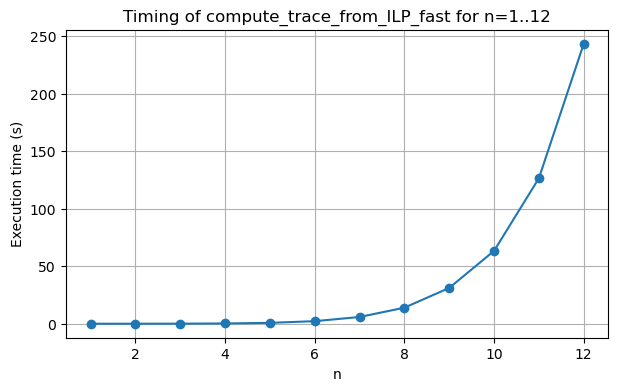

In [101]:
import sympy as sp
import numpy as np
import time
import matplotlib.pyplot as plt

A = sp.Matrix([
    [2, -1, 3],
    [5,  1, 1],
    [1,  0, 2]
])

ns = list(range(1, 13))
times = []

for n in ns:
    start = time.time()

    result = solve_su3_pieri_ilp(n, debug=False)
    subs = {sp.symbols(c): val for c, val in zip("abcdefghi", A)}
    total, details = compute_trace_from_ILP_fast(A, result, subs)

    end = time.time()
    times.append(end - start)
    print(f"n={n} done, time = {end-start:.3f}s")

plt.figure(figsize=(7,4))
plt.plot(ns, times, marker="o")
plt.xlabel("n")
plt.ylabel("Execution time (s)")
plt.title("Timing of compute_trace_from_ILP_fast for n=1..12")
plt.grid()
plt.show()


In [25]:
# 3x3 numeric matrix
A = sp.Matrix([
    [2, -1, 3],
    [5,  1, 1],
    [1,  0, 2]
])
n = 10
result = solve_su3_pieri_ilp(n, debug=False)


# Create a substitution dict for the 3×3 symbols a..i
subs = {sp.symbols(c): val for c, val in zip(
    "abcdefghi", A
)}

# Compute ILP trace
total, details = compute_trace_from_ILP(A, result, subs)

print("Total trace =", total)
for d in details:
    print(d)

print("Should be equal to:", A.trace() ** n)

Total trace = 9765625.00000000
{'a_raw': (1, 0, 0), 'b_raw': (9, 0, 0), 'selected': -34.0, 'trA': 5, 'trB': 10375, 'contrib': -1763750.00000000}
{'a_raw': (2, 0, 0), 'b_raw': (8, 0, 0), 'selected': -40.0, 'trA': 15, 'trB': 3875, 'contrib': -2325000.00000000}
{'a_raw': (3, 0, 0), 'b_raw': (7, 0, 0), 'selected': -15.0, 'trA': 35, 'trB': 1375, 'contrib': -721875.000000000}
{'a_raw': (4, 0, 0), 'b_raw': (6, 0, 0), 'selected': 48.0, 'trA': 75, 'trB': 475, 'contrib': 1710000.00000000}
{'a_raw': (5, 0, 0), 'b_raw': (5, 0, 0), 'selected': 42.0, 'trA': 175, 'trB': 175, 'contrib': 1286250.00000000}
{'a_raw': (7, 0, 0), 'b_raw': (1, 1, 1), 'selected': -287.0, 'trA': 1375, 'trB': 10, 'contrib': -3946250.00000000}
{'a_raw': (8, 0, 0), 'b_raw': (1, 1, 0), 'selected': 8.0, 'trA': 3875, 'trB': 10, 'contrib': 310000.000000000}
{'a_raw': (2, 0, 0), 'b_raw': (5, 0, 0), 'selected': 27.0, 'trA': 15, 'trB': 175, 'contrib': 708750.000000000}
{'a_raw': (3, 0, 0), 'b_raw': (4, 0, 0), 'selected': 288.0, 'trA': 

In [106]:
%lprun -f compute_trace_from_ILP_fast compute_trace_from_ILP_fast(A, result, subs)

Timer unit: 1e-07 s

Total time: 393.939 s
File: C:\Users\martin\AppData\Local\Temp\ipykernel_1680\829207970.py
Function: compute_trace_from_ILP_fast at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def compute_trace_from_ILP_fast(A, result, subs):
     8         1          5.0      5.0      0.0      total = 0
     9         1          4.0      4.0      0.0      detailed = []
    10         1       1787.0   1787.0      0.0      A_num = np.array(A, dtype=float)
    11         1        661.0    661.0      0.0      detA = np.linalg.det(A_num)
    12                                           
    13                                               # Preload all unique reps
    14         1          8.0      8.0      0.0      labels = set()
    15        15         69.0      4.6      0.0      for entry in result["solution"]:
    16        14        102.0      7.3      0.0          labels.add(entry["candidate"][0])
    17

In [54]:
import numpy as np

def A_tensor_k(A, k):
    """
    Compute the k-fold tensor product of a square matrix A: A ⊗ A ⊗ ... ⊗ A (k times)
    """
    result = A.copy()
    for _ in range(1, k):
        result = np.kron(result, A)
    return result

def trace_tensor_k(A, k):
    """
    Compute the trace of the k-fold tensor product of A.
    """
    A_k = A_tensor_k(A, k)
    return np.trace(A_k)

# -----------------------------------------------------
# Example usage
# -----------------------------------------------------
A = np.array([
    [2, -1, 3],
    [5,  1, 1],
    [1,  0, 2]
], dtype=float)
print("Trace A =", np.trace(A))
print("Determinant A =", np.linalg.det(A))
k = 10  # number of tensor products
A_k = A_tensor_k(A, k)
trA_k = trace_tensor_k(A, k)

print(f"A^{k}-fold tensor shape:", A_k.shape)
print(f"Trace(A^{k}-fold tensor) =", trA_k)


Trace A = 5.0
Determinant A = 9.999999999999998
A^10-fold tensor shape: (59049, 59049)
Trace(A^10-fold tensor) = 9765625.0


In [103]:
import numpy as np
import time
import matplotlib.pyplot as plt

def A_tensor_k(A, k):
    result = A.copy()
    for _ in range(1, k):
        result = np.kron(result, A)
    return result

def trace_tensor_k(A, k):
    A_k = A_tensor_k(A, k)
    return np.trace(A_k)

A = np.array([
    [2, -1, 3],
    [5,  1, 1],
    [1,  0, 2]
], dtype=float)

ks = list(range(1, 13))   
times = []
shapes = []

for k in ks:
    start = time.time()
    tr = trace_tensor_k(A, k)
    end = time.time()

    shape = (3**k, 3**k)
    shapes.append(shape)
    times.append(end - start)

    print(f"k={k}: shape={shape}, time={end-start:.3f}s, trace={tr}")

# Plot timing
plt.figure(figsize=(7,4))
plt.plot(ks, times, marker="o")
plt.xlabel("k")
plt.ylabel("time (s)")
plt.title("Timing of A ⊗ ... ⊗ A (k times) and its trace")
plt.grid(True)
plt.show()


k=1: shape=(3, 3), time=0.000s, trace=5.0
k=2: shape=(9, 9), time=0.000s, trace=25.0
k=3: shape=(27, 27), time=0.000s, trace=125.0
k=4: shape=(81, 81), time=0.000s, trace=625.0
k=5: shape=(243, 243), time=0.000s, trace=3125.0
k=6: shape=(729, 729), time=0.003s, trace=15625.0
k=7: shape=(2187, 2187), time=0.026s, trace=78125.0
k=8: shape=(6561, 6561), time=0.252s, trace=390625.0
k=9: shape=(19683, 19683), time=2.329s, trace=1953125.0
k=10: shape=(59049, 59049), time=32.663s, trace=9765625.0


MemoryError: Unable to allocate 234. GiB for an array with shape (59049, 3, 59049, 3) and data type float64

In [82]:
asd = read_sympy_matrix_csv("piM_sym_9.csv")